#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Описание данных

**Признаки**
- datetime — дата


**Целевой признак**
- num_orders - количество заказов

### Импорт библиотек

In [1]:
!pip install -U scikit-learn
!pip install imbalanced-learn
!pip install lightgbm
!pip install catboost

^C


In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit
)    
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from time import time
%matplotlib notebook
%matplotlib inline

In [3]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
pd.options.display.max_columns = None


### Константы

In [4]:
LAGS = [1,2,24,168]
ROLLS = [24]

### Информация о столбцах:

In [5]:
data_name = 'Данные о заказах такси'
data_fields = {    
'datetime':['дата', True],
'num_orders':['Количество заказов', True]
}

### Функция получения информации о столбце

In [6]:
def col_reaper(ddf,param_name,plot_hist = True):
    global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    
    #Определение имени столбца
    if data_fields.get(param_name)[0] is not None:
        field = data_fields.get(param_name)[0]
    else:
        field = ''
        
    #Описание данных
    print('')
    print('\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' +  'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) >0:
       print('\033[4m' +  'Пропущено:' + '\033[0m', sum(param.isna()))
       print('')

    #Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
#    if plot_hist and not 'str' in str(typer):
#        print('\nГистограмма значений:')
#        param.hist();
    if plot_hist and not 'str' in str(typer):
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param.plot(kind='hist',bins=20,figsize=(12,5), grid = True)
            plt.title(field)
            #plt.xlabel('Населенные пункты') 
            plt.ylabel('Количество записей')
            plt.xticks(rotation=0)
            plt.show()
            
    else:
        if len(param.unique())<=40:
            #param_index = param.reset_index()
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group=ddf.groupby(param_name).agg(cnt=(param_name,'count')).reset_index()
            display(param_group.sort_values(by='cnt',ascending=False).reset_index(drop=True).head(10))
            #param_group = ddf.pivot_table(index=param_name, aggfunc=['count','mean'])[0]
            #display(param_group.head(10))
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar',figsize=(12,5))
            #param_group.plot(kind='pie', x=param_name, y='count', autopct='%1.0f%%', figsize=(6,6))
            plt.title(field)
            plt.xlabel('') 
            plt.ylabel('Количество записей')
            if len(param.unique())<=20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')
    

### Функция получения информации о датафрейме

In [7]:
def df_reaper(df, df_name ='', data_fields = {}):
    # Список столюцов для гистограмм, диаграмм, корелляции и т.п.
    cols = df.columns
    true_cols = []
    for col in cols:
        #print(col,data_fields.get(col))
        if data_fields.get(col)[1]:
            true_cols.append(col)

    print('\033[1;4m' +  df_name + '\033[0m \n')   
    print('\033[1m' +  'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' +  'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' +  'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' +  'Дубликаты:' + '\033[0m')
    if df.duplicated().sum() > 0:
        print ('Обнаружено дубликатов', df.duplicated().sum())
    else:    
        print ('Дубликатов не обнаружено')
    print('')
    
    print('\033[1m' +  'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    #display(describer(df[true_cols]))
    display(df.describe().T)

 
    print('\033[1m' +  'Столбцы:' + '\033[0m \n')
 #   cols = df.columns

    for col in cols:
        if data_fields.get(col)[0] is not None:
            field = data_fields.get(col)[0]
        else:
            field = ''
        print('\033[1;3m' +  col + ' - ' + field + '\033[0m')
        plot_hist = data_fields.get(col)[1]
        col_reaper(df,col,plot_hist)

### Загрузка

In [8]:
try:
    data = pd.read_csv('datasets/taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

In [9]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


## Анализ

### Анализ датасета

Данные о заказах такси 

Количество записей:


26496


Первые 5 строк данных:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

Дубликаты:
Дубликатов не обнаружено

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
num_orders,"26,496.00",14.07,9.21,0.00,8.00,13.00,19.00,119.00


Столбцы: 

datetime - дата

Описание данных:
count                   26496
unique                  26496
top       2018-03-01 00:00:00
freq                        1
Name: datetime, dtype: object
Количество записей: 26496 из 26496

Тип:
 <class 'str'>

num_orders - Количество заказов

Описание данных:
count   26,496.00
mean        14.07
std          9.21
min          0.00
25%          8.00
50%         13.00
75%         19.00
max        119.00
Name: num_orders, dtype: float64
Количество записей: 26496 из 26496

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


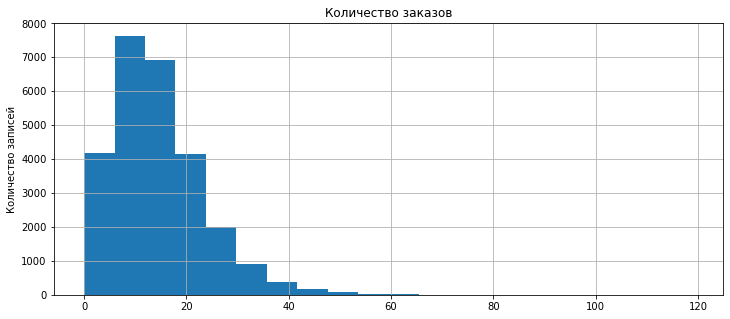

In [10]:
df_reaper(data, data_name, data_fields)

### Перезагрузка датасета

Перезагрузим Dataset, задав индексы в виде дат

In [11]:
import datetime as dt
try:
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Проверка временного индекса на последовательность и отсутствие пропусков 

In [12]:
if data.index.is_monotonic:
    print('Данные последовательны, пропуски отсутствуют')
else:
    print('Данные непоследовательны и/или присутствуют пропуски')

Данные последовательны, пропуски отсутствуют


### Ресемплирование

Ресемплируем данные по дням

In [13]:
data_hours = data.resample('1H').sum()

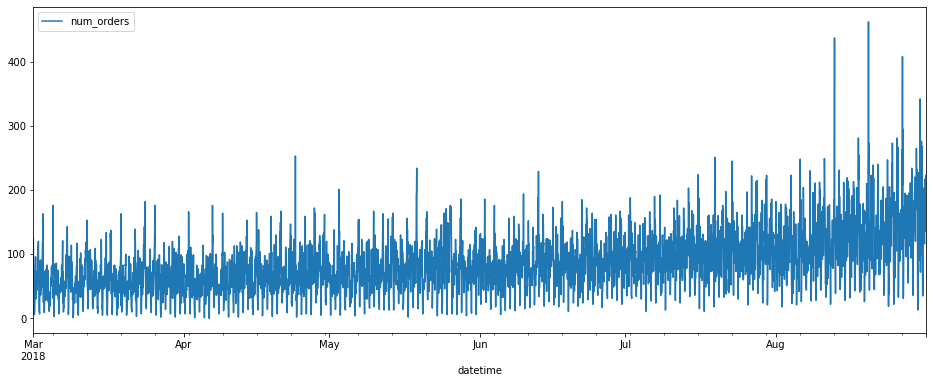

In [14]:
data_hours.plot(figsize=(16, 6));

Дисперсия увеличивается

### Декомпозиция

#### За весь период:

In [15]:
decomposed = seasonal_decompose(data_hours)

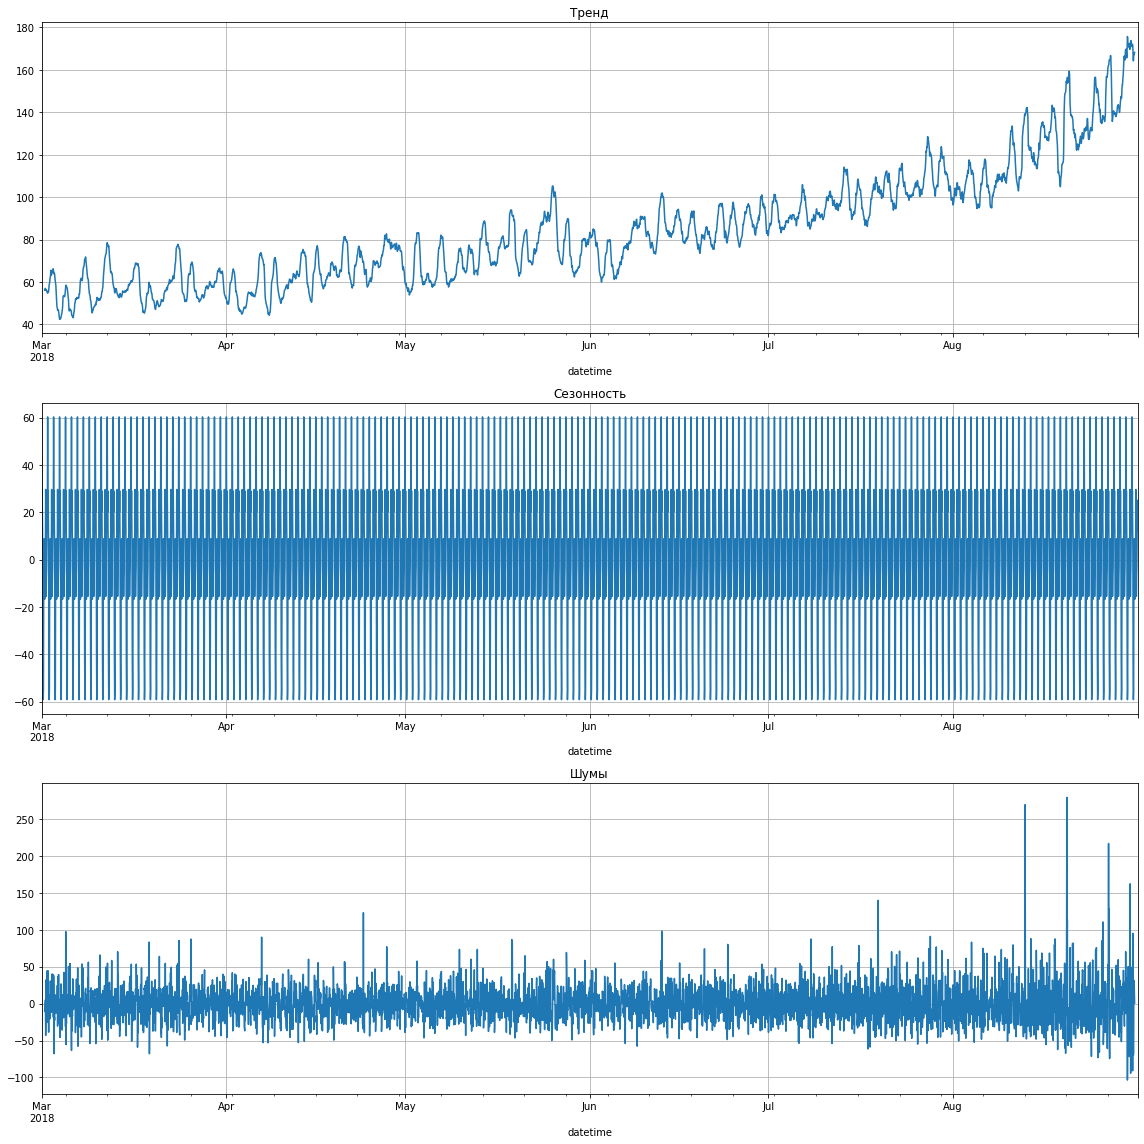

In [16]:
decomposed = seasonal_decompose(data_hours)
plt.figure(figsize=(16, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(),grid=True)
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(),grid=True)
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(),grid=True)
plt.title('Шумы')
plt.tight_layout()

Тренд показывает, что постепенно количество заказов растет.  <br />
Чтобы понять сезонность - стоит посмотреть на более коротком периоде

#### За последние 15 дней:

Послелний день статистики - 31.08.2018 - пятница. <br /> Рассмотрим данные за последние 15 дней - от пятницы 17.08.18 до пятницы 31.08.18:

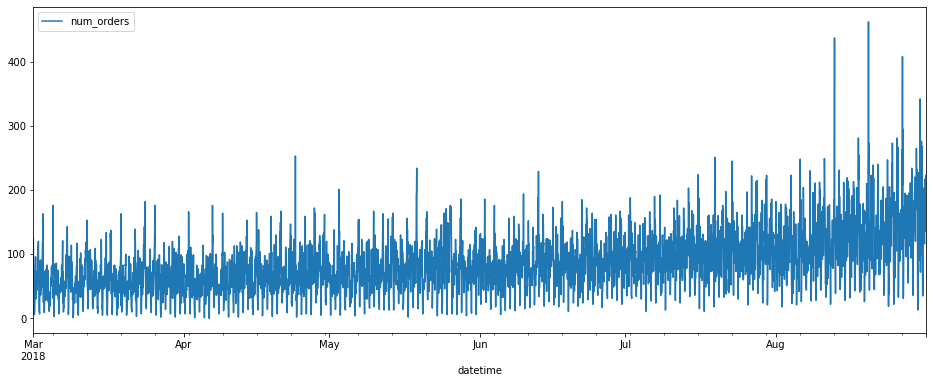

In [17]:
data_hours.plot(figsize=(16, 6));

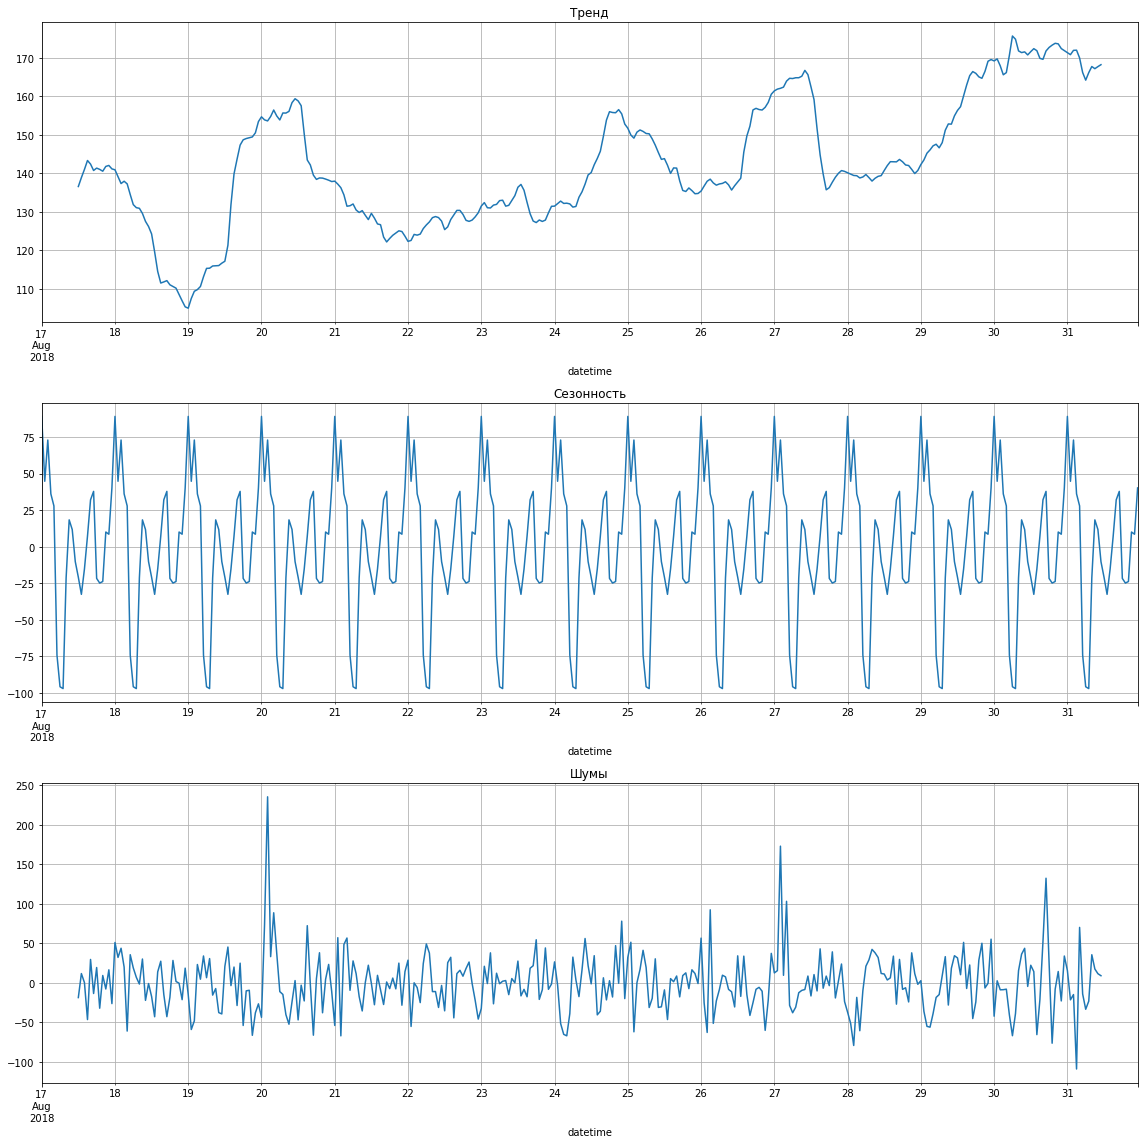

In [18]:
decomposed_week = seasonal_decompose(data_hours['2018-08-17':'2018-08-31'])
plt.figure(figsize=(16, 16))
plt.subplot(311)
plt.grid(which='minor')
decomposed_week.trend.plot(ax=plt.gca(),grid=True)
plt.title('Тренд')
plt.subplot(312)
plt.grid(which='minor')
decomposed_week.seasonal.plot(ax=plt.gca(),grid=True)
plt.title('Сезонность')
plt.subplot(313)
plt.grid(which='minor')
decomposed_week.resid.plot(ax=plt.gca(),grid=True)
plt.title('Шумы')
plt.tight_layout()

В тренде присутствует общий рост, больше всего заказов в четверг-субботу и понедельник-вторник.<br>
Судя по сезонности - меньше всаго заказов утром, больше - днем, пик - вечероми ночью

### Итоги анализа данных:

1. Датасет содержит 26496 записей за период с 01.03.2018 по 31.08.2018
2. Данные полны, дубликаты, выбросы отсутствуют
3. Временные данные последовательны, пропуски отсутствуют
4. Данные ресемплированы суммированием по 1 часу
5. Тренд возрастающий, в августе - резкий рост
6. Больше всего заказов в четверг-субботу и понедельник-вторник
7. Сезонность имеет суточный период, меньше всаго заказов утром, больше - днем, пик - вечероми ночью

## Обучение

### Функция, формирующая признаки

In [19]:
def make_features(df, max_lag, rolling_size):
    
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
   

In [20]:
data_hours.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


### Разбивка на обучающую и тестовую выборку

In [21]:
train, test = train_test_split(data_hours, shuffle=False, test_size=0.1)

### Подбор количества фолдов для кросс-валидации

 Для кросс-валидации будет использоваться метод "кросс-валидация на скользящем окне" (cross-validation on a rolling basis).
 За размер окна примем неделю, то есть 24*7 = 168 записей

In [22]:
# Here put the number you want in test data,
# I used 1 because your example has only 1 test data in each split
num_in_test = 168

test_size = float(num_in_test) / len(train)

num_splits = int((1//test_size)-1)
print ('Количество фолдов:',num_splits)

Количество фолдов: 22


In [23]:
1//test_size

23.0

### Модель DummyRegressor

Используем как критерий адекватности модель DummyRegressor

In [24]:
start = time()
dummy_best_score = 1000
strategies = ['mean','median']
dummy_score= []

#for lag in range(1,MAX_LAG+1):
for lag in LAGS:
    #print('lag = ', lag)
    for roll in ROLLS:
        #print('roll =',roll)
        train_calc = train.copy()
        make_features(train_calc, lag, roll)
        train_calc = train_calc.dropna()
        features_train = train_calc.drop('num_orders', axis = 1)
        target_train = train_calc['num_orders']
        for s in strategies:
            dummy = DummyRegressor(strategy = s)
            dummy.fit(features_train, target_train)
            tscv = TimeSeriesSplit(n_splits=num_splits)
            scores = -1*cross_val_score(dummy, features_train,target_train, cv=tscv, scoring='neg_root_mean_squared_error')
            result = sum(scores) / len(scores)
            if result < dummy_best_score:
                dummy_best_score = result
                dummy_best_lag = lag
                dummy_best_roll = roll
                dummy_best_strategy = s
                dummy_best_model = dummy
dummy_time = time() - start

In [25]:
print('Наилучшее значение RMSE: {:.2f}'.format(dummy_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(dummy_best_lag))
print('rolling_size: {:.0f}'.format(dummy_best_roll))
print('Стратегия: {0}'.format(dummy_best_strategy))
print('Время подбора гиперпараметров: {:.2f} сек.'.format(dummy_time))

Наилучшее значение RMSE: 38.30
Параметры:
max_lag: 1
rolling_size: 24
Стратегия: mean
Время подбора гиперпараметров: 5.29 сек.


### Модель Linear Regression

In [26]:
start = time()
linear_best_score = 1000
for lag in LAGS:
    for roll in ROLLS:
        train_calc = train.copy()
        make_features(train_calc, lag, roll)
        train_calc = train_calc.dropna()
        features_train = train_calc.drop('num_orders', axis = 1)
        target_train = train_calc['num_orders']
        model = LinearRegression()
        model.fit(features_train, target_train)
        tscv = TimeSeriesSplit(n_splits=num_splits)
        scores = -1*cross_val_score(model, features_train,target_train, cv=tscv, scoring='neg_root_mean_squared_error')
        result = sum(scores) / len(scores)
        if result < linear_best_score:
            linear_best_score = result
            linear_best_lag = lag
            linear_best_roll = roll
            linear_best_model = model
linear_time = time() - start

In [27]:
print('Наилучшее значение RMSE: {:.2f}'.format(linear_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(linear_best_lag))
print('rolling_size: {:.0f}'.format(linear_best_roll))
print('Время подбора гиперпараметров: {:.2f} сек.'.format(linear_time))

Наилучшее значение RMSE: 25.95
Параметры:
max_lag: 24
rolling_size: 24
Время подбора гиперпараметров: 4.72 сек.


### Модель Решающее дерево

In [28]:
start = time()
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 10)]
param_dist = {'max_depth': max_depth}
tree_best_score = 1000

for lag in LAGS:
    for roll in ROLLS:
        train_calc = train.copy()
        make_features(train_calc, lag, roll)
        train_calc = train_calc.dropna()
        features_train = train_calc.drop('num_orders', axis = 1)
        target_train = train_calc['num_orders']
        dtr = DecisionTreeRegressor(random_state=1176)
        tscv = TimeSeriesSplit(n_splits=num_splits)
        rs = RandomizedSearchCV(dtr, 
                        param_dist, 
                        n_iter = 10, 
                        scoring = 'neg_root_mean_squared_error',
                        cv = tscv, 
                        verbose = False, 
                        n_jobs=-1, 
                        random_state=1176)
        rs.fit(features_train, target_train);
        result_tree = abs(rs.best_score_)
        if result_tree < tree_best_score:
            tree_best_score = result_tree
            tree_best_lag = lag
            tree_best_roll = roll
            tree_best_model = rs.best_estimator_
            tree_best_params = rs.best_params_
    
tree_time = time() - start

In [29]:
print('Наилучшее значение RMSE: {:.2f}'.format(tree_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(tree_best_lag))
print('rolling_size: {:.0f}'.format(tree_best_roll))
print('Гиперпараметры модели:', tree_best_params)
print('Время подбора гиперпараметров: {:.2f} сек.'.format(tree_time))


Наилучшее значение RMSE: 25.25
Параметры:
max_lag: 168
rolling_size: 24
Гиперпараметры модели: {'max_depth': 4}
Время подбора гиперпараметров: 32.22 сек.


### Модель CatBoost

In [30]:
start = time()
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 51, num = 5)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 7, num = 4)]
learning_rate = [0.25, 0.5, 0.75]


param_dist = {'n_estimators': n_estimators,
              'max_depth':max_depth,
              'learning_rate': learning_rate
             }
cbr_best_score = 1000

for lag in LAGS:
    for roll in ROLLS:
        train_calc = train.copy()
        make_features(train_calc, lag, roll)
        train_calc = train_calc.dropna()
        features_train = train_calc.drop('num_orders', axis = 1)
        target_train = train_calc['num_orders']
        cbr = CatBoostRegressor(silent=True)
        tscv = TimeSeriesSplit(n_splits=num_splits)
        rs = RandomizedSearchCV(cbr, 
                        param_dist, 
                        n_iter = 10, 
                        scoring = 'neg_root_mean_squared_error',
                        cv = tscv, 
                        verbose = False, 
                        n_jobs=-1, 
                        random_state=1176)
        rs.fit(features_train, target_train);
        result = abs(rs.best_score_)
        if result < cbr_best_score:
            cbr_best_score = result
            cbr_best_lag = lag
            cbr_best_roll = roll
            cbr_best_model = rs.best_estimator_
            cbr_best_params = rs.best_params_
cbr_time = time() - start

In [31]:
print('Наилучшее значение RMSE: {:.2f}'.format(cbr_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(cbr_best_lag))
print('rolling_size: {:.0f}'.format(cbr_best_roll))
print('Гиперпараметры модели:', cbr_best_params)
print('Время подбора гиперпараметров: {:.2f} сек.'.format(cbr_time))

Наилучшее значение RMSE: 21.74
Параметры:
max_lag: 168
rolling_size: 24
Гиперпараметры модели: {'n_estimators': 51, 'max_depth': 5, 'learning_rate': 0.25}
Время подбора гиперпараметров: 122.00 сек.


### Итоги моделирования

Наилучший результат на тестовой выборке показала модель CatBoost

In [32]:
print('Наилучшее значение RMSE: {:.2f}'.format(cbr_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(cbr_best_lag))
print('rolling_size: {:.0f}'.format(cbr_best_roll))
print('Гиперпараметры модели:', cbr_best_params)
print('Время подбора гиперпараметров: {:.2f} сек.'.format(cbr_time))

Наилучшее значение RMSE: 21.74
Параметры:
max_lag: 168
rolling_size: 24
Гиперпараметры модели: {'n_estimators': 51, 'max_depth': 5, 'learning_rate': 0.25}
Время подбора гиперпараметров: 122.00 сек.


## Тестирование

### Проверка наилучшей модели на тестовой выборке:

In [33]:
test_calc = test.copy()
make_features(test_calc, cbr_best_lag, cbr_best_roll)
test_calc =  test_calc.dropna()
features_test = test_calc.drop('num_orders', axis = 1)
target_test = test_calc['num_orders']
predict_test = cbr_best_model.predict(features_test)
test_result = mean_squared_error(predict_test,target_test)**0.5

In [34]:
print('RMSE модели: {:.2f}'.format(test_result))

RMSE модели: 41.57


Это значительно больше значения, показанного на тренировочной выборке, но удовлетворяет условиям задачи.<br /> 
Скорее всего, причина в резком росте тренда в августе, особенно в его второй половине, к которой и относятся тестовые данные

### Сравнение целевого признака и предсказаний на тестовой выборке

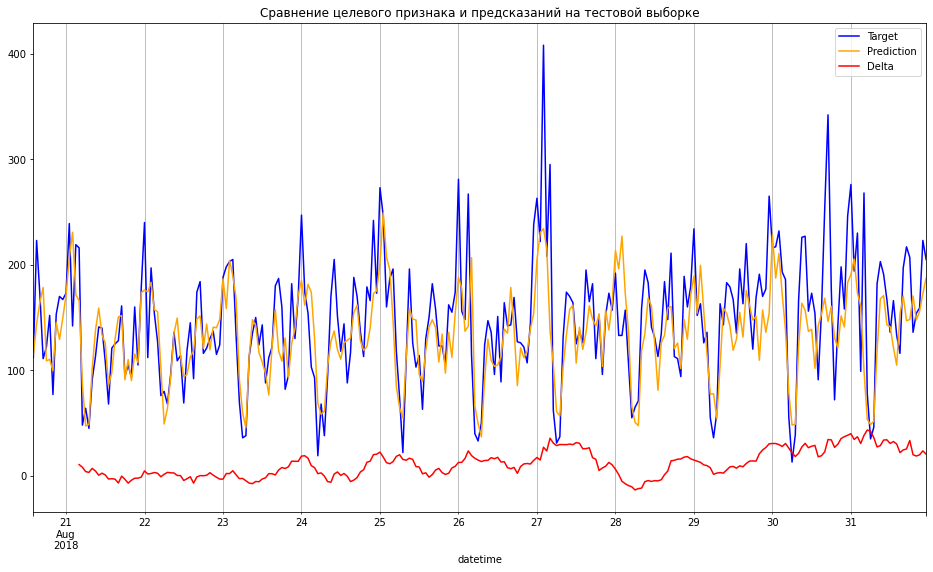

In [35]:
predict_test = pd.Series(predict_test, index=target_test.index)
delta = (target_test - predict_test).rolling(15).mean()
fig, ax = plt.subplots(figsize=(16, 9))
plt.grid(which='both')
target_test.plot(color='blue',label='Target')
predict_test.plot(color='orange',label='Prediction')
delta.plot(color='red',label='Delta')
plt.title('Сравнение целевого признака и предсказаний на тестовой выборке')
ax.legend()
plt.plot(grid=True);

Из графика видно, что средние значения целевого признака и предсказаний на тестовой выборке близки, но в пиках есть отличия. Усредненная разница между значениями невелика.

In [36]:
delta.mean()

11.547977583721392

In [37]:
predict_test_up = predict_test + delta.mean()
test_result_up = mean_squared_error(predict_test_up,target_test)**0.5
test_result_up

39.87941643320993

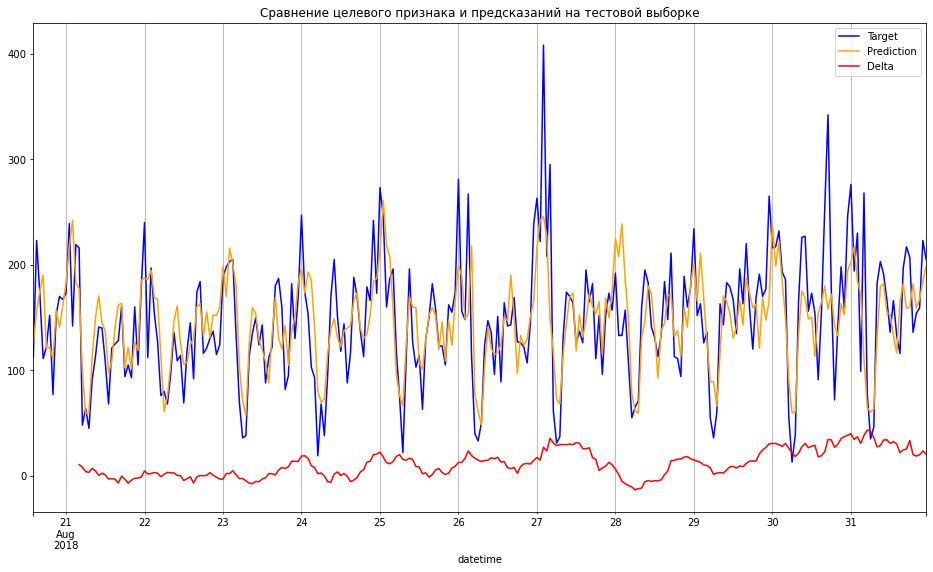

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.grid(which='both')
target_test.plot(color='blue',label='Target')
predict_test_up.plot(color='orange',label='Prediction')
delta.plot(color='red',label='Delta')
plt.title('Сравнение целевого признака и предсказаний на тестовой выборке')
ax.legend()
plt.plot(grid=True);

### Результат тестирования:

In [39]:
print('RMSE наилучшей модели (CatBoost) на тестовой выборке: {:.2f}'.format(test_result))

RMSE наилучшей модели (CatBoost) на тестовой выборке: 41.57


## Итоги проекта

### Анализ данных:

1. Датасет содержит 26496 записей за период с 01.03.2018 по 31.08.2018
2. Данные полны, дубликаты, выбросы отсутствуют
3. Временные данные последовательны, пропуски отсутствуют
4. Данные ресемплированы суммированием по 1 часу
5. Тренд возрастающий, в августе - резкий рост
6. Больше всего заказов в четверг-субботу и понедельник-вторник
7. Сезонность имеет суточный период, меньше всаго заказов утром, больше - днем, пик - вечероми ночью

### Обучение

Проведено моделирование с использованием моделей "DummyRegressor" (в качестве меры адекватности моделей), "LinearRegression", "Решающее дерево" и "CatBoost".
Оценка моделей проводилась на обучающей выборке (10% последних записей) метрикой RMSE.

In [40]:
print('Модель DummyRegressor')
print('Наилучшее значение RMSE: {:.2f}'.format(dummy_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(dummy_best_lag))
print('rolling_size: {:.0f}'.format(dummy_best_roll))
print('Стратегия: {0}'.format(dummy_best_strategy))
print('Время подбора гиперпараметров: {:.2f} сек.'.format(dummy_time))

Модель DummyRegressor
Наилучшее значение RMSE: 38.30
Параметры:
max_lag: 1
rolling_size: 24
Стратегия: mean
Время подбора гиперпараметров: 5.29 сек.


In [41]:
print('Модель LinearRegression')
print('Наилучшее значение RMSE: {:.2f}'.format(linear_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(linear_best_lag))
print('rolling_size: {:.0f}'.format(linear_best_roll))
print('Время подбора гиперпараметров: {:.2f} сек.'.format(linear_time))

Модель LinearRegression
Наилучшее значение RMSE: 25.95
Параметры:
max_lag: 24
rolling_size: 24
Время подбора гиперпараметров: 4.72 сек.


In [42]:
print('Модель Решающее дерево')
print('Наилучшее значение RMSE: {:.2f}'.format(tree_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(tree_best_lag))
print('rolling_size: {:.0f}'.format(tree_best_roll))
print('Гиперпараметры модели:', tree_best_params)
print('Время подбора гиперпараметров: {:.2f} сек.'.format(tree_time))

Модель Решающее дерево
Наилучшее значение RMSE: 25.25
Параметры:
max_lag: 168
rolling_size: 24
Гиперпараметры модели: {'max_depth': 4}
Время подбора гиперпараметров: 32.22 сек.


In [43]:
print('Модель CatBoost')
print('Наилучшее значение RMSE: {:.2f}'.format(cbr_best_score))
print('Параметры:')
print('max_lag: {:.0f}'.format(cbr_best_lag))
print('rolling_size: {:.0f}'.format(cbr_best_roll))
print('Гиперпараметры модели:', cbr_best_params)
print('Время подбора гиперпараметров: {:.2f} сек.'.format(cbr_time))

Модель CatBoost
Наилучшее значение RMSE: 21.74
Параметры:
max_lag: 168
rolling_size: 24
Гиперпараметры модели: {'n_estimators': 51, 'max_depth': 5, 'learning_rate': 0.25}
Время подбора гиперпараметров: 122.00 сек.


Наилучший результат показала модель CatBoost

### Тестирование

In [44]:
print('RMSE наилучшей модели (CatBoost) на тестовой выборке: {:.2f}'.format(test_result))

RMSE наилучшей модели (CatBoost) на тестовой выборке: 41.57


### Общий итог проекта

Создана модель для предсказания количества заказов такси на следующий час на основании исторических данных.
Модель протестирована согласно условиям проекта.